In [ ]:
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(7)

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 5.0MB/s eta 0:00:01


In [ ]:
!pip install -q scikit-multilearn

     |████████████████████████████████| 92kB 5.5MB/s eta 0:00:011


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import string
import gensim
from gensim.models import Word2Vec, KeyedVectors
import keras
from keras.layers.core import Reshape, Flatten
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, LSTM, MaxPooling1D, concatenate
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.models import Model
from keras.initializers import RandomUniform, glorot_uniform
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, hamming_loss, f1_score
import matplotlib.pyplot as plt

import io
import random
import joblib

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

%matplotlib inline

Using TensorFlow backend.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving priority_10k_labelled.csv to priority_10k_labelled.csv


In [ ]:
data = pd.read_csv('priority_10k_labelled.csv')
data.head()

,reviews,category_sentiment,category,sentiment
0,Kotor berdebu. Saya tdk berhenti bersin ketika...,wifi_P1-neg,wifi_P1,neg
1,Kotor berdebu. Saya tdk berhenti bersin ketika...,kebersihan-neg,kebersihan,neg
2,kamar ada semutnya. kamar mandi bermasalah. bu...,kebersihan-neg,kebersihan,neg
3,"Kamar mandi bau, airnya bau",bau_P1-neg,bau_P1,neg
4,"tak sesuai espektasi, kamar sempit, pintu kama...",service-neg,service,neg


In [ ]:
def get_all_label(x_train, y_train):
    y_train_set = []
    sent = x_train[0]
    X_train_set = [sent]
    labels = []
    for i in range (len(x_train)):
        if sent != x_train[i]:
            if (len(labels)>0):
                y_train_set.append(labels)
            sent = x_train[i]
            X_train_set.append(sent)
            labels = []
        labels.append(y_train[i])
    return X_train_set, y_train_set

def tokenize(msg):
    clean = [char for char in msg if char not in string.punctuation]
    clean = ''.join(clean)
    return clean.lower().split()

def find_maxlen(reviews):
    longest = 0
    strlong = "test"
    for review in reviews:
        if len(tokenize(review)) > longest:
            longest = len(tokenize(review))
            strlong = review
    return longest

def train_w2v(corpus, size, min_count):
    docs = [tokenize(doc) for doc in corpus]
    model = gensim.models.Word2Vec(docs,
                                   size=size,
                                   window=10,
                                   min_count=min_count,
                                   workers=10)
    model.train(docs, total_examples=len(docs), epochs=10)
    return model

def tokenize_text(vocab_size, reviews,maxlen):
    tokenizer = Tokenizer(num_words=vocab_size, lower=True, oov_token='<UNK>')
    tokenizer.fit_on_texts(reviews)
    sequences = tokenizer.texts_to_sequences(reviews)
    x = pad_sequences(sequences, maxlen=maxlen)
    return x, tokenizer

def createEmbeddingMatrix(word_index, vocab_size, dim, word_vectors):
    EMBEDDING_DIM=dim
    vocabulary_size=min(len(word_index)+1,vocab_size)
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i>=vocab_size:
            continue
        try:
            embedding_vector = word_vectors[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
    return embedding_matrix
  
def create_conv_layers(num_filters, filter_sizes, embedding, conv_activation):
  conv_layers = []
  for s in filter_sizes:
    conv = Conv1D(num_filters, s, activation=conv_activation, kernel_initializer=glorot_uniform(seed=random.seed(7)), kernel_regularizer=regularizers.l2(0.01))(embedding)
    conv_layers.append(conv)
  return conv_layers

def max_pools(maxlen, filter_sizes, conv_layers):
  pools = []
  for i in range(len(conv_layers)):
    pool = MaxPooling1D(maxlen - filter_sizes[i] + 1, strides=1)(conv_layers[i])
    pools.append(pool)
  return pools

def createCNNModel(filter_sizes, num_filters, embedding_matrix, conv_activation, dense_units, embedding_dim, vocabulary_size, maxlen, num_classes):
    filter_sizes = filter_sizes
    num_filters = num_filters
    drop = 0.5
    
    inputs = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocabulary_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=True)
    embedding = embedding_layer(inputs)
    
    convs = create_conv_layers(num_filters, filter_sizes, embedding, conv_activation)
    pools = max_pools(maxlen, filter_sizes, convs)
    merged_tensor = concatenate(pools, axis=1)

    flatten = Flatten()(merged_tensor)
    
    dense1 = Dense(dense_units, kernel_initializer=RandomUniform(seed=random.seed(7)))(flatten)
    dropout = Dropout(drop)(dense1)
    
    output = Dense(units=num_classes, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(dropout)
    
    # this creates a model that includes
    model = Model(inputs, output)
    #print(model.summary())
    return model

def createCNNLSTMModel(filter_sizes, num_filters, embedding_matrix, conv_activation, dense_units, embedding_dim, vocabulary_size, maxlen, num_classes):
    filter_sizes = filter_sizes
    num_filters = num_filters
    drop = 0.5
    
    inputs = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocabulary_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=True)
    embedding = embedding_layer(inputs)
    
    convs = create_conv_layers(num_filters, filter_sizes, embedding, conv_activation)
    pools = max_pools(maxlen, filter_sizes, convs)
    merged_tensor = concatenate(pools, axis=1)
    
    dense1 = Dense(dense_units, kernel_initializer=RandomUniform(seed=random.seed(7)))(merged_tensor)
    dropout = Dropout(drop)(dense1)
    lstm_1 = LSTM(64)(dropout)
    output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(lstm_1)
    
    # this creates a model that includes
    model = Model(inputs, output)
    #print(model.summary())
    return model
   

def fit_cnn(x_train, y_train, x_val, y_val, filters, window_sizes, embedding_matrix, conv_activation, dense_units, epochs, filepath, earlystop):
  model = None
  model = createCNNModel(window_sizes, filters, embedding_matrix, conv_activation, dense_units, 400, 5000, 350, 10)
  adam = Adam(lr=1e-3)
  model.compile(loss='binary_crossentropy', metrics=['categorical_accuracy'],
              optimizer=adam)
  if earlystop:
    callbacks = [EarlyStopping(patience=4),
            ModelCheckpoint(filepath=filepath, save_best_only=True)]
  else:
    callbacks = [ModelCheckpoint(filepath=filepath, save_best_only=True)]
  
  t0 = time()  
  results = model.fit(x_train, y_train, batch_size=32, epochs=epochs, callbacks=callbacks, verbose=0, validation_data = (x_val, y_val))
  training_time = time()-t0
  
  cnn_model = keras.models.load_model(filepath)
  metrics = cnn_model.evaluate(x_val, y_val)
  
  y_pred = cnn_model.predict(x_val)
  y_pred_bool = np.array([[0 if x <= 0.5 else 1 for x in arr] for arr in y_pred])
  f1_macro = f1_score(y_val, y_pred_bool, average='macro')
  f1_micro = f1_score(y_val, y_pred_bool, average='micro')  
  hamloss = hamming_loss(y_val,y_pred_bool)
  
  return results, metrics, f1_macro, f1_micro, hamloss, training_time

def fit_and_evaluate_cnn_lstm(x_train, y_train, x_val, y_val, filters, window_sizes, embedding_matrix, conv_activation, dense_units, epochs, filepath, earlystop):
  model = None
  model = createCNNLSTMModel(window_sizes, filters, embedding_matrix, conv_activation, dense_units, 400, 5000, 350, 10)
  adam = Adam(lr=1e-3)
  model.compile(loss='binary_crossentropy', metrics=['categorical_accuracy'],
              optimizer=adam)
  if earlystop:
    callbacks = [EarlyStopping(patience=4),
            ModelCheckpoint(filepath=filepath, save_best_only=True)]
  else:
    callbacks = [ModelCheckpoint(filepath=filepath, save_best_only=True)]
  
  t0 = time()  
  results = model.fit(x_train, y_train, batch_size=32, epochs=epochs, callbacks=callbacks, verbose=0, validation_data = (x_val, y_val))
  training_time = time()-t0
  
  model = keras.models.load_model(filepath)
  metrics = model.evaluate(x_val, y_val)
  
  y_pred = model.predict(x_val)
  y_pred_bool = np.array([[0 if x <= 0.1 else 1 for x in arr] for arr in y_pred])
  f1_macro = f1_score(y_val, y_pred_bool, average='macro')
  f1_micro = f1_score(y_val, y_pred_bool, average='micro')  
  hamloss = hamming_loss(y_val,y_pred_bool)
  
  return results, metrics, f1_macro, f1_micro, hamloss, training_time

def get_output_cnn(model, x_train, x_test):
    total_layers = len(model.layers)
    fl_index = total_layers-1
    feature_layer_model = Model(
                     inputs=model.input,
                     outputs=model.get_layer(index=fl_index).output)
    x_train_xg = feature_layer_model.predict(x_train)
    x_test_xg = feature_layer_model.predict(x_test)
    return x_train_xg, x_test_xg

In [ ]:
data = data[data.sentiment != 'ignored']
data.reset_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18476 entries, 0 to 18475
Data columns (total 5 columns):
index                 18476 non-null int64
reviews               18476 non-null object
category_sentiment    18476 non-null object
category              18476 non-null object
sentiment             18476 non-null object
dtypes: int64(1), object(4)
memory usage: 721.8+ KB


In [ ]:
data.category.value_counts()

kebersihan         4006
linen_P1           2739
service            2684
ac_P1              2057
air_panas_P1       1459
wifi_P1            1421
bau_P1             1413
general            1083
tv_P1               914
sunrise_meal_P1     700
Name: category, dtype: int64

In [ ]:
X_train, y_train = get_all_label(data['reviews'], data['category'])

In [ ]:
data_train = list(zip(X_train, y_train))
random.Random(7).shuffle(data_train)

In [ ]:
df_train = pd.DataFrame(data_train, columns=['review', 'labels'])
df_train.head()

,review,labels
0,Ada beberapa fasilitas yg tidak diberikan yait...,"[wifi_P1, sunrise_meal_P1]"
1,Air panas nya tidak ada,[air_panas_P1]
2,Kamarnya sangat kotor dan bau,"[kebersihan, bau_P1]"
3,lama pelayanannya. ac panas banget ga nyenyak ...,"[service, ac_P1]"
4,"Beda banget sama yang difoto, kotor.",[kebersihan]


In [ ]:
len(data_train)

9450

In [ ]:
cardinality = sum([len(i) for i in df_train['labels']])/len(df_train['labels'])
density = sum([len(i)/len(mlb.classes_) for i in df_train['labels']])/len(df_train['labels'])
print("Label Cardinality: ", cardinality)
print("Label Density: ", density)

NameError: ignored

In [ ]:
find_maxlen(df_train.review)

320

In [ ]:
def load_w2v(link):
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('w2v_model.bin')
  word_vectors = KeyedVectors.load_word2vec_format('w2v_model.bin', binary=True)
  return word_vectors

In [ ]:
word_vectors = load_w2v('https://drive.google.com/open?id=1lNfCSpRAW601ZLWSWF_P9y8C89xpVkpi')

W0809 09:56:57.368371 139964296607616 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [ ]:
import tensorflow as tf
inputs = Input(shape=(350,))
embedding_layer = Embedding(5000,
                            400,
                            weights=[embedding_matrix])
embedding = embedding_layer(inputs)
model = Model(inputs, embedding)
emb = model.predict(x)

In [ ]:
emb.shape

(4, 350, 400)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_train.review, df_train['labels'], test_size=0.2, random_state=1)

In [ ]:
x_train = df_train.review
y_train = df_train['labels']

In [ ]:
train = list(zip(x_train, list(y_train)))
df_train_raw = pd.DataFrame(train, columns=['review', 'labels'])
df_train_raw.head()

,review,labels
0,Ada beberapa fasilitas yg tidak diberikan yait...,"[wifi_P1, sunrise_meal_P1]"
1,Air panas nya tidak ada,[air_panas_P1]
2,Kamarnya sangat kotor dan bau,"[kebersihan, bau_P1]"
3,lama pelayanannya. ac panas banget ga nyenyak ...,"[service, ac_P1]"
4,"Beda banget sama yang difoto, kotor.",[kebersihan]


In [ ]:
path = 'train_raw.csv'
df_train_raw.to_csv(path)
file = drive.CreateFile({'title' : path})
file.SetContentFile(path)
file.Upload()

In [ ]:
test = list(zip(x_test, y_test))
df_test_raw = pd.DataFrame(test, columns=['review', 'labels'])
df_test_raw.head()

,review,labels
0,kamar yg didapat tidak sesuai yg di foto & san...,[bau_P1]
1,WiFi gak Hidup,[wifi_P1]
2,"kamar terlalu luas, sayang cuma bisa untuk 2 o...","[kebersihan, linen_P1, wifi_P1, sunrise_meal_P1]"
3,Kamarnya bagus pelayanannya baik cuma wifi yg ...,"[service, wifi_P1]"
4,Kamarx sempit.... Handukx terlambat di berikan...,[linen_P1]


In [ ]:
path = 'test_raw.csv'
df_test_raw.to_csv(path)
file = drive.CreateFile({'title' : path})
file.SetContentFile(path)
file.Upload()

In [ ]:
mlb = MultiLabelBinarizer()
y = df_train['labels']
y = mlb.fit(y)
y_train = mlb.transform(y_train)
#y_test = mlb.transform(y_test)
mlb.classes_

array(['ac_P1', 'air_panas_P1', 'bau_P1', 'general', 'kebersihan',
       'linen_P1', 'service', 'sunrise_meal_P1', 'tv_P1', 'wifi_P1'],
      dtype=object)

In [ ]:
x_train, tokenizer = tokenize_text(5000, x_train, 350)
embedding_matrix = embedding_matrix = createEmbeddingMatrix(tokenizer.word_index, 5000, 400, word_vectors)
#x_test = tokenizer.texts_to_sequences(x_test)
#x_test = pad_sequences(x_test, 350)

In [ ]:
x_train.shape

(9448, 350)

In [ ]:
df_y_train = pd.DataFrame(y_train, columns=mlb.classes_)
#df_y_test = pd.DataFrame(y_test, columns=mlb.classes_)

In [ ]:
counts = []
for category in df_y_train:
    counts.append((category, df_y_train[category].value_counts()[1]))
df_stats_train = pd.DataFrame(counts, columns=['category', 'number_of_review'])
df_stats_train

,category,number_of_review
0,ac_P1,2056
1,air_panas_P1,1459
2,bau_P1,1414
3,general,1083
4,kebersihan,4000
5,linen_P1,2738
6,service,2682
7,sunrise_meal_P1,700
8,tv_P1,914
9,wifi_P1,1422


In [ ]:
counts = []
for category in df_y_test:
    counts.append((category, df_y_test[category].value_counts()[1]))
df_stats_test = pd.DataFrame(counts, columns=['category', 'number_of_review'])
df_stats_test

,category,number_of_review
0,ac_P1,410
1,air_panas_P1,300
2,bau_P1,275
3,general,224
4,kebersihan,784
5,linen_P1,548
6,service,520
7,sunrise_meal_P1,138
8,tv_P1,178
9,wifi_P1,292


In [ ]:
import os

path = 'model-cnn.h5'
path_dir = os.path.dirname(path)

# Training CNN


---



In [ ]:
import pickle
from sklearn.model_selection import KFold
from time import time

In [ ]:
kfold = KFold(5, True, random_state=7)
#n_folds=5

window_sizes_all = [[2,3,4]]
for window_sizes in window_sizes_all:
  filters = 128
  conv_activation = 'relu'
  dense_units = 256
  epochs=50
  file_history = 'model_history-' + str(filters) + '-' + str(window_sizes) + '-' + conv_activation + '-' + str(dense_units) + '-' + str(epochs)
  path_best = 'model-cnn-'+ str(filters) + '-' + str(window_sizes) + '-' + conv_activation + '-' + str(dense_units)+ 'cv.h5'
  path_cv_result = 'cv-res-'+ str(filters) + '-' + str(window_sizes) + '-' + conv_activation + '-' + str(dense_units) + '-' + str(epochs) + '.csv'

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  #save the model history in a list after fitting so that we can plot later
  model_history = [] 
  table_cnn = []

  i=0
  for t, v in kfold.split(x_train, y_train):
    print("Training on Fold: ",i+1)
    t_x = x_train[t]
    val_x = x_train[v]
    t_y = y_train[t]
    val_y = y_train[v]
    
    history, metrics, f1_macro, f1_micro, hamloss, training_time = fit_cnn(t_x, t_y, val_x, val_y, filters, window_sizes, embedding_matrix, conv_activation, dense_units, epochs, path, False)
    loss = metrics[0]
    categorical_accuracy = metrics[1]
    print(loss)
    print(categorical_accuracy)
    
    model_history.append(history)
    print("======="*12, end="\n\n\n")
    
    table_cnn += [[loss, categorical_accuracy, f1_macro, f1_micro, hamloss, training_time]]
    
    i+=1
    
  df_cnn = pd.DataFrame(table_cnn, columns=['losses', 'categorical_accuracies', 'f1_macro', 'f1_micro', 'hamloss', 'time'], index=range(1,len(table_cnn)+1))
  df_cnn.to_csv(path_cv_result)
  file = drive.CreateFile({'title' : path_cv_result})
  file.SetContentFile(path_cv_result)
  file.Upload()
    
  with open(file_history, 'wb') as pickle_file:
    pickle.dump(model_history, pickle_file)
      
  file = drive.CreateFile({'title' : file_history})
  file.SetContentFile(file_history)
  file.Upload()

Training on Fold:  1
1890/1890 [==============================] - 3s 2ms/step
0.12170638334814203
0.662962962962963


Training on Fold:  2
1890/1890 [==============================] - 3s 2ms/step
0.1288348745495554
0.5962962962962963


Training on Fold:  3
1890/1890 [==============================] - 4s 2ms/step
0.1263500382660558
0.6126984126984127


Training on Fold:  4
1890/1890 [==============================] - 4s 2ms/step
0.13781547808142566
0.6439153439153439


Training on Fold:  5
1890/1890 [==============================] - 4s 2ms/step
0.12891965590456805
0.6074074074074074




In [ ]:
cnn_model = keras.models.load_model(path_best)
metrics = cnn_model.evaluate(x_test, y_test)
print("{}: {}".format(cnn_model.metrics_names[0], metrics[0]))
print("{}: {}".format(cnn_model.metrics_names[1], metrics[1]))

1890/1890 [==============================] - 8s 4ms/step
loss: 0.1474211360411669
categorical_accuracy: 0.6931216931216931


In [ ]:
y_pred = cnn_model.predict(x_test)
y_pred_bool = np.array([[0 if x <= 0.5 else 1 for x in arr] for arr in y_pred])
print(classification_report(y_test,y_pred_bool, target_names=mlb.classes_, digits=4))
print(hamming_loss(y_test,y_pred_bool))

                 precision    recall  f1-score   support

          ac_P1     0.9736    0.9878    0.9806       410
   air_panas_P1     0.9697    0.9600    0.9648       300
         bau_P1     0.8993    0.9418    0.9201       275
        general     0.8789    0.7455    0.8068       224
     kebersihan     0.9406    0.9286    0.9345       784
       linen_P1     0.9514    0.8212    0.8815       548
        service     0.8950    0.9019    0.8985       520
sunrise_meal_P1     0.9444    0.8623    0.9015       138
          tv_P1     0.9556    0.9663    0.9609       178
        wifi_P1     0.9824    0.9555    0.9688       292

      micro avg     0.9392    0.9092    0.9240      3669
      macro avg     0.9391    0.9071    0.9218      3669
   weighted avg     0.9391    0.9092    0.9230      3669
    samples avg     0.9306    0.9221    0.9154      3669

0.029047619047619048


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [ ]:
x_train_xg, x_test_xg = get_output_cnn(cnn_model, x_train, x_test)

In [ ]:
clf = ClassifierChain(XGBClassifier(), order=[0,1,9,8,5,4,2,3,7,6])
clf.fit(x_train_xg, y_train)
y_pred = clf.predict(x_test_xg)
y_pred = y_pred.todense().tolist()
for p in y_pred:
  p[0], p[1], p[9], p[8], p[5], p[4], p[2], p[3], p[7], p[6] =  p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9]
y_pred = np.array(y_pred)
print(classification_report(y_test,y_pred, target_names=mlb.classes_, digits=4))
hamloss = hamming_loss(y_test,y_pred)
print(hamloss)

                 precision    recall  f1-score   support

          ac_P1     0.9712    0.9878    0.9794       410
   air_panas_P1     0.9698    0.9633    0.9666       300
         bau_P1     0.9167    0.9200    0.9183       275
        general     0.8214    0.8214    0.8214       224
     kebersihan     0.9320    0.9439    0.9379       784
       linen_P1     0.8982    0.9015    0.8998       548
        service     0.8835    0.9192    0.9010       520
sunrise_meal_P1     0.9071    0.9203    0.9137       138
          tv_P1     0.9508    0.9775    0.9640       178
        wifi_P1     0.9828    0.9760    0.9794       292

      micro avg     0.9235    0.9346    0.9290      3669
      macro avg     0.9234    0.9331    0.9282      3669
   weighted avg     0.9237    0.9346    0.9291      3669
    samples avg     0.9264    0.9424    0.9242      3669

0.027724867724867725


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


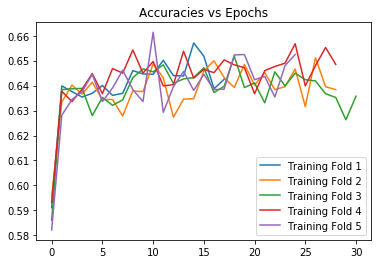

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['categorical_accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['categorical_accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['categorical_accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['categorical_accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['categorical_accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

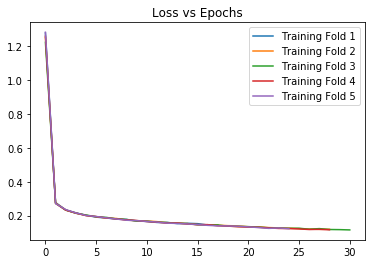

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title('Loss vs Epochs')
plt.plot(model_history[0].history['loss'], label='Training Fold 1')
plt.plot(model_history[1].history['loss'], label='Training Fold 2')
plt.plot(model_history[2].history['loss'], label='Training Fold 3')
plt.plot(model_history[3].history['loss'], label='Training Fold 4')
plt.plot(model_history[4].history['loss'], label='Training Fold 5')
plt.legend()
plt.show()
plt.savefig('loss-cnn.png')

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
# model.save('model.h5')    
file = drive.CreateFile({'title' : 'loss-cnn.png'})
file.SetContentFile('loss-cnn.png')
file.Upload()

In [ ]:
from statistics import mean
min_epoch = min([len(l) for l in [q.history['loss'] for q in model_history]])
losses = [l for l in [q.history['loss'] for q in model_history]]
min_loss = min([l for l in[mean(q) for q in [[p[i] for p in losses]  for i in range(min_epoch)]]])
avg_losses = [mean(q) for q in [[p[i] for p in losses]  for i in range(min_epoch)]]
epochs = avg_losses.index(min_loss)+1
epochs

14

# Extract CNN Feature

---



In [ ]:
x_train_xg, x_test_xg = get_output_cnn(cnn_model, x_train, x_test)
category = mlb.classes_.tolist()

# Training XGBoost-BR

---



In [ ]:


table = []
training_times = []
prediction_times = []
losses = []
categorical_accuracies = []

n_folds=5
epochs=100

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train_xg, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    clf = BinaryRelevance(XGBClassifier())
    clf.fit(t_x, t_y)
    y_pred = clf.predict(val_x)
    #print(classification_report(val_y,y_pred, target_names=category, digits=4))
    print(f1_score(val_y, y_pred, average='macro'))
    print(hamming_loss(val_y,y_pred))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
0.948016641346394
0.01984126984126984


Training on Fold:  2
0.935566165881298
0.02275132275132275


Training on Fold:  3
0.9385460033492011
0.02328042328042328


Training on Fold:  4
0.9420967874300601
0.020370370370370372


Training on Fold:  5
0.9426659781959652
0.020370370370370372




In [ ]:
y_pred = clf.predict(x_test_xg)
print(classification_report(y_test,y_pred, target_names=category, digits=4))
print(hamming_loss(y_test,y_pred))

                 precision    recall  f1-score   support

          ac_P1     0.9852    0.9901    0.9877       202
   air_panas_P1     0.9583    0.9650    0.9617       143
         bau_P1     0.8712    0.9595    0.9132       148
        general     0.7981    0.7477    0.7721       111
     kebersihan     0.9123    0.9100    0.9111       400
       linen_P1     0.8924    0.9113    0.9018       282
        service     0.8931    0.9035    0.8983       259
sunrise_meal_P1     0.8857    0.8857    0.8857        70
          tv_P1     0.9271    0.9570    0.9418        93
        wifi_P1     0.9648    0.9580    0.9614       143

      micro avg     0.9118    0.9217    0.9167      1851
      macro avg     0.9088    0.9188    0.9135      1851
   weighted avg     0.9117    0.9217    0.9165      1851
    samples avg     0.9142    0.9298    0.9095      1851

0.03202479338842975


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# Training XGBoost-CC

In [ ]:
n_folds=5
epochs=100

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train_xg, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    clf = ClassifierChain(XGBClassifier(), order=[0,1,9,8,5,4,2,3,7,6])
    clf.fit(t_x, t_y)
    y_pred = clf.predict(val_x)
    
    y_pred = y_pred.todense().tolist()
    for p in y_pred:
      p[0], p[1], p[9], p[8], p[5], p[4], p[2], p[3], p[7], p[6] =  p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9]
    y_pred = np.array(y_pred)
    
    #print(classification_report(val_y,y_pred, target_names=category, digits=4))
    print(f1_score(val_y, y_pred, average='macro'))
    print(hamming_loss(val_y,y_pred))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
0.9421596876380646
0.0208994708994709


Training on Fold:  2
0.9334688402173166
0.021957671957671957


Training on Fold:  3
0.9528088879367862
0.018518518518518517


Training on Fold:  4
0.9282952328508678
0.023544973544973546


Training on Fold:  5
0.9507289216437403
0.017724867724867723




In [ ]:
y_pred = clf.predict(x_test_xg)

y_pred = y_pred.todense().tolist()
for p in y_pred:
  p[0], p[1], p[9], p[8], p[5], p[4], p[2], p[3], p[7], p[6] =  p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9]
y_pred = np.array(y_pred)

print(classification_report(y_test,y_pred, target_names=category, digits=4))
print(hamming_loss(y_test,y_pred))

                 precision    recall  f1-score   support

          ac_P1     0.9804    0.9901    0.9852       202
   air_panas_P1     0.9517    0.9650    0.9583       143
         bau_P1     0.8659    0.9595    0.9103       148
        general     0.7778    0.7568    0.7671       111
     kebersihan     0.9102    0.9125    0.9114       400
       linen_P1     0.8897    0.9149    0.9021       282
        service     0.8893    0.8996    0.8944       259
sunrise_meal_P1     0.9143    0.9143    0.9143        70
          tv_P1     0.9368    0.9570    0.9468        93
        wifi_P1     0.9648    0.9580    0.9614       143

      micro avg     0.9091    0.9238    0.9164      1851
      macro avg     0.9081    0.9228    0.9151      1851
   weighted avg     0.9092    0.9238    0.9163      1851
    samples avg     0.9102    0.9302    0.9074      1851

0.032231404958677684


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# Training SVM-BR

In [ ]:
n_folds=5
epochs=100

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train_xg, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    svm_clf = BinaryRelevance(LinearSVC())
    svm_clf.fit(t_x, t_y)
    y_pred = svm_clf.predict(val_x)
    #print(classification_report(val_y,y_pred, target_names=category, digits=4))
    print(f1_score(val_y, y_pred, average='macro'))
    print(hamming_loss(val_y,y_pred))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
0.9401880023731074
0.021957671957671957


Training on Fold:  2
0.9433721664649102
0.020105820105820106


Training on Fold:  3
0.9271586797358417
0.02328042328042328


Training on Fold:  4
0.9253212608440109
0.02142857142857143


Training on Fold:  5
0.9453795615759152
0.01746031746031746




In [ ]:
y_pred = svm_clf.predict(x_test_xg)
print(classification_report(y_test,y_pred, target_names=category, digits=4))
print(hamming_loss(y_test,y_pred))

                 precision    recall  f1-score   support

          ac_P1     0.9801    0.9752    0.9777       202
   air_panas_P1     0.9583    0.9650    0.9617       143
         bau_P1     0.8462    0.9662    0.9022       148
        general     0.8058    0.7477    0.7757       111
     kebersihan     0.9211    0.8750    0.8974       400
       linen_P1     0.9094    0.8901    0.8996       282
        service     0.9016    0.8842    0.8928       259
sunrise_meal_P1     0.9118    0.8857    0.8986        70
          tv_P1     0.9362    0.9462    0.9412        93
        wifi_P1     0.9716    0.9580    0.9648       143

      micro avg     0.9169    0.9065    0.9117      1851
      macro avg     0.9142    0.9093    0.9112      1851
   weighted avg     0.9173    0.9065    0.9114      1851
    samples avg     0.9085    0.9122    0.8972      1851

0.033574380165289255


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# Training SVM-CC

In [ ]:
n_folds=5
epochs=100

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train_xg, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    svm_clf = ClassifierChain(LinearSVC(), order=[0,1,9,8,5,4,2,3,7,6])
    svm_clf.fit(t_x, t_y)
    y_pred = svm_clf.predict(val_x)
    
    y_pred = y_pred.todense().tolist()
    for p in y_pred:
      p[0], p[1], p[9], p[8], p[5], p[4], p[2], p[3], p[7], p[6] =  p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9]
    y_pred = np.array(y_pred)
    
    #print(classification_report(val_y,y_pred, target_names=category, digits=4))
    print(f1_score(val_y, y_pred, average='macro'))
    print(hamming_loss(val_y,y_pred))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
0.9489714985742014
0.018783068783068783


Training on Fold:  2
0.9440544129196136
0.020634920634920634


Training on Fold:  3
0.9362990777608038
0.018518518518518517


Training on Fold:  4
0.9353568854833535
0.022222222222222223


Training on Fold:  5
0.9294096714665295
0.02328042328042328




In [ ]:
y_pred = svm_clf.predict(x_test_xg)

y_pred = y_pred.todense().tolist()
for p in y_pred:
    p[0], p[1], p[9], p[8], p[5], p[4], p[2], p[3], p[7], p[6] =  p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9]

y_pred = np.array(y_pred)

print(classification_report(y_test,y_pred, target_names=category, digits=4))
print(hamming_loss(y_test,y_pred))

                 precision    recall  f1-score   support

          ac_P1     0.9801    0.9752    0.9777       202
   air_panas_P1     0.9517    0.9650    0.9583       143
         bau_P1     0.8462    0.9662    0.9022       148
        general     0.8155    0.7568    0.7850       111
     kebersihan     0.9206    0.8700    0.8946       400
       linen_P1     0.9061    0.8901    0.8980       282
        service     0.9051    0.8842    0.8945       259
sunrise_meal_P1     0.9118    0.8857    0.8986        70
          tv_P1     0.9362    0.9462    0.9412        93
        wifi_P1     0.9716    0.9580    0.9648       143

      micro avg     0.9169    0.9060    0.9114      1851
      macro avg     0.9145    0.9097    0.9115      1851
   weighted avg     0.9173    0.9060    0.9111      1851
    samples avg     0.9087    0.9119    0.8971      1851

0.033677685950413226


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# Training CNN-LSTM

In [ ]:
import os
path_lstm = 'model-cnn-lstm.h5'
path_lstm_best = 'model-cnn-lstm-cv.h5'
path_dir2 = os.path.dirname(path_lstm)

In [ ]:
kfold = KFold(5, True, random_state=7)
#n_folds=5
filters = 128
window_sizes = [2,3,4]
conv_activation = 'relu'
dense_units = 128
epochs=50
file_history = 'model_history-cnn-lstm' + str(filters) + '-' + str(window_sizes) + '-' + conv_activation + '-' + str(dense_units) + '-' + str(epochs)
path_best = 'model-cnn-lstm'+ str(filters) + '-' + str(window_sizes) + '-' + conv_activation + '-' + str(dense_units)+ 'cv.h5'
path_cv_result = 'cv-res-cnn-lstm'+ str(filters) + '-' + str(window_sizes) + '-' + conv_activation + '-' + str(dense_units) + '-' + str(epochs) + '.csv'

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#save the model history in a list after fitting so that we can plot later
model_history = [] 
table_cnn = []

i=0
for t, v in kfold.split(x_train, y_train):
  print("Training on Fold: ",i+1)
  t_x = x_train[t]
  val_x = x_train[v]
  t_y = y_train[t]
  val_y = y_train[v]
  
  history, metrics, f1_macro, f1_micro, hamloss, training_time = fit_and_evaluate_cnn_lstm(t_x, t_y, val_x, val_y, filters, window_sizes, embedding_matrix, conv_activation, dense_units, epochs, path_lstm, False)
  
  loss = metrics[0]
  categorical_accuracy = metrics[1]
  print(loss)
  print(categorical_accuracy)
    
  model_history.append(history)
  print("======="*12, end="\n\n\n")
  
  table_cnn += [[loss, categorical_accuracy, f1_macro, f1_micro, hamloss, training_time]]
  
  i+=1

df_cnn = pd.DataFrame(table_cnn, columns=['loss', 'categorical_accuracy', 'f1_macro', 'f1_micro', 'hamloss', 'training_time'], index=range(1,len(table_cnn)+1))
df_cnn.to_csv(path_cv_result)
file = drive.CreateFile({'title' : path_cv_result})
file.SetContentFile(path_cv_result)
file.Upload()

with open(file_history, 'wb') as pickle_file:
    pickle.dump(model_history, pickle_file)
    
file = drive.CreateFile({'title' : file_history})
file.SetContentFile(file_history)
file.Upload()
  

Training on Fold:  1
1890/1890 [==============================] - 2s 1ms/step
0.2667665350058722
0.6693121693121693


Training on Fold:  2
1890/1890 [==============================] - 2s 1ms/step
0.2728298464780131
0.6915343915343916


Training on Fold:  3
1890/1890 [==============================] - 3s 1ms/step
0.25997536002643523
0.6497354497354497


Training on Fold:  4
1890/1890 [==============================] - 3s 2ms/step
0.2783584881081152
0.7074074074074074


Training on Fold:  5
1890/1890 [==============================] - 3s 2ms/step
0.2777385256435505
0.6798941798941799




In [ ]:
df_cnn_lstm= pd.DataFrame(table_cnn_lstm, columns=['losses', 'categorical_accuracies', 'f1_macros', 'f1_micros', 'hamming_losses'], index=range(1,len(table_cnn_lstm)+1))
display(df_cnn_lstm)

,losses,categorical_accuracies,f1_macros,f1_micros,hamming_losses
1,0.268547,0.680952,0.911407,0.914316,0.034392
2,0.278082,0.665079,0.914081,0.915930,0.033704
3,0.269599,0.662963,0.916053,0.917060,0.033439
4,0.270085,0.616402,0.913846,0.915192,0.033968
5,0.267452,0.689947,0.917779,0.919789,0.032169


In [ ]:
print(df_cnn_lstm.f1_micros.mean())
print(df_cnn_lstm.f1_macros.mean())
print(df_cnn_lstm.hamming_losses.mean())

0.9164572927453895
0.9146331356109757
0.03353439153439154


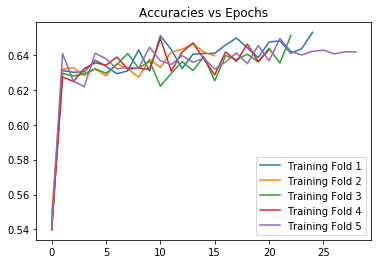

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['categorical_accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['categorical_accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['categorical_accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['categorical_accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['categorical_accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

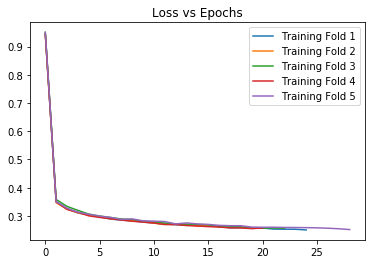

In [ ]:
plt.title('Loss vs Epochs')
plt.plot(model_history[0].history['loss'], label='Training Fold 1')
plt.plot(model_history[1].history['loss'], label='Training Fold 2')
plt.plot(model_history[2].history['loss'], label='Training Fold 3')
plt.plot(model_history[3].history['loss'], label='Training Fold 4')
plt.plot(model_history[4].history['loss'], label='Training Fold 5')
plt.legend()
plt.show()

In [ ]:
cnn_lstm_model = keras.models.load_model(path_lstm_best)
metrics = cnn_lstm_model.evaluate(x_test, y_test)
print("{}: {}".format(cnn_lstm_model.metrics_names[0], metrics[0]))
print("{}: {}".format(cnn_lstm_model.metrics_names[1], metrics[1]))

1890/1890 [==============================] - 3s 1ms/step
loss: 0.26745191907125804
categorical_accuracy: 0.68994708994709


In [ ]:
y_pred = cnn_lstm_model.predict(x_test)
y_pred_bool = (y_pred > 0.1)
y_pred = np.array([[0 if x==False else 1 for x in arr] for arr in y_pred_bool])
print(classification_report(y_test,y_pred, target_names=category, digits=4))
print(hamming_loss(y_test,y_pred))

                 precision    recall  f1-score   support

          ac_P1     0.9687    0.9805    0.9745       410
   air_panas_P1     0.8743    0.9733    0.9211       300
         bau_P1     0.8758    0.9491    0.9110       275
        general     0.7659    0.8616    0.8109       224
     kebersihan     0.9086    0.9758    0.9410       784
       linen_P1     0.8249    0.9544    0.8849       548
        service     0.8945    0.9135    0.9039       520
sunrise_meal_P1     0.9071    0.9203    0.9137       138
          tv_P1     0.9405    0.9775    0.9587       178
        wifi_P1     0.9786    0.9384    0.9580       292

      micro avg     0.8913    0.9501    0.9198      3669
      macro avg     0.8939    0.9444    0.9178      3669
   weighted avg     0.8939    0.9501    0.9205      3669
    samples avg     0.9160    0.9638    0.9264      3669

0.03216931216931217
